### יבוא סיפריות 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_hist_gradient_boosting  # נדרש עבור HistGradientBoostingClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, 
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    HistGradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV, 
    train_test_split, 
    RepeatedStratifiedKFold, 
    RandomizedSearchCV, 
    StratifiedShuffleSplit
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    roc_auc_score, 
    recall_score, 
    precision_score, 
    f1_score, 
    auc, 
    precision_recall_curve, 
    make_scorer, 
    ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance
from sklearn.ensemble import VotingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from scipy import stats
from scipy.stats import chisquare
from scipy.interpolate import interp1d

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

# Set seaborn style for plots
sns.set_style('darkgrid')

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\97254\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


# EDA

In [2]:
df = pd.read_csv("Roni Project (2).csv")
df = df.copy()
# Rename columns to lowercase
df.columns = df.columns.str.lower()

# Display the shape and columns
print(df.shape)
print(df.columns)
df.describe()
df.info()

(71991, 28)
Index(['user', 'deposit_attempts', 'sucess_deposit_attempts', 'num_crads',
       'num_crads_success', 'first_deposit_date', 'last_deposit_date',
       'deposit_sucess_ratio', 'deposit_time_delta', 'signup_time_delta',
       'calls', 'docs_uploaded', 'docs_approved', 'approval_rate',
       'sales_view', 'conversion_owner', 'sales_agent',
       'account_create_on_date', 'country_name', 'tag', 'channel',
       'ava_business', 'profile_state', 'num_closed_trades',
       'business_group_name', 'first_closed_trade_date',
       'last_closed_trade_date', 'is_ch_back'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71991 entries, 0 to 71990
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user                     71991 non-null  int64  
 1   deposit_attempts         71991 non-null  int64  
 2   sucess_deposit_attempts  71991 non-null  int64  
 3   num_cr

### המרת לפורמט של תאריך

In [3]:

df['first_deposit_date'] = pd.to_datetime(df['first_deposit_date'])
df['last_deposit_date'] = pd.to_datetime(df['last_deposit_date'])
df['account_create_on_date'] = pd.to_datetime(df['account_create_on_date'])
df['first_closed_trade_date'] = pd.to_datetime(df['first_closed_trade_date'])
df['last_closed_trade_date'] = pd.to_datetime(df['last_closed_trade_date'])


### למידה על ערכים חסרים 

In [4]:
# בדיקת חוסר בנתונים
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])
# בדיקת כמות השורות שבהן הערך של num_crads הוא אפס
num_crads_zero_count = (df['num_crads'] == 0).sum()
print(f"Number of rows where 'num_crads' is zero: {num_crads_zero_count}")


last_deposit_date            16
first_closed_trade_date    7171
last_closed_trade_date     7171
dtype: int64
Number of rows where 'num_crads' is zero: 19954


In [5]:
# מספר השורות עם ערך חסר בעמודה 'last_deposit_date'
num_missing_last_deposit_date = df['last_deposit_date'].isnull().sum()
print(f"Number of rows with missing 'last_deposit_date': {num_missing_last_deposit_date}")

# שמירת הדאטה פריים לאחר הסרת השורות עם ערך חסר בעמודה 'last_deposit_date'
df_cleaned_last_deposit = df.dropna(subset=['last_deposit_date'])

# מספר השורות בהן 'is_ch_back' הוא 1 לאחר הניקוי
num_ch_back_1_after_cleaning = df_cleaned_last_deposit['is_ch_back'].sum()
print(f"Number of rows where 'is_ch_back' is 1 after cleaning rows with missing 'last_deposit_date': {num_ch_back_1_after_cleaning}")


Number of rows with missing 'last_deposit_date': 16
Number of rows where 'is_ch_back' is 1 after cleaning rows with missing 'last_deposit_date': 301


### חישוב עמודות חדשות 

In [6]:
# רשימת עמודות בהן יש להחליף ערכים של 0 בערכים חסרים
columns_to_replace_zeros = ['deposit_attempts', 'sucess_deposit_attempts', 'num_crads', 'num_crads_success']

# החלפת ערכים של 0 בערכים חסרים (NaN)
df[columns_to_replace_zeros] = df[columns_to_replace_zeros].replace(0, np.nan)


In [7]:
# הפרש ימים בין ההפקדה הראשונה להפקדה האחרונה
df['days_between_deposits'] = (df['last_deposit_date'] - df['first_deposit_date']).dt.days

# הפרש ימים בין יצירת החשבון להפקדה הראשונה
df['days_to_first_deposit'] = (df['first_deposit_date'] - df['account_create_on_date']).dt.days

# הפרש ימים בין העסקה הסגורה הראשונה לעסקה הסגורה האחרונה
df['days_between_trades'] = (df['last_closed_trade_date'] - df['first_closed_trade_date']).dt.days

# יחס הצלחה של עסקאות סגורות
df['success_ratio_crads'] = df['num_crads_success'] / df['num_crads']

# יחס אישור מסמכים
df['approval_ratio_docs'] = df['docs_approved'] / df['docs_uploaded']

# זמן ממוצע בין הפקדות
df['avg_days_between_deposits'] = df['deposit_time_delta'] / df['deposit_attempts']

# זמן ממוצע בין עסקאות סגורות
df['avg_days_between_trades'] = df['signup_time_delta'] / df['num_closed_trades']

# חודש ההפקדה הראשונה
df['first_deposit_month'] = df['first_deposit_date'].dt.month

# חודש ההפקדה האחרונה
df['last_deposit_month'] = df['last_deposit_date'].dt.month

# יום בשבוע של ההפקדה הראשונה
df['first_deposit_weekday'] = df['first_deposit_date'].dt.weekday

# הצגת התוצאות
print(df.shape)
print(df.columns)

(71991, 38)
Index(['user', 'deposit_attempts', 'sucess_deposit_attempts', 'num_crads',
       'num_crads_success', 'first_deposit_date', 'last_deposit_date',
       'deposit_sucess_ratio', 'deposit_time_delta', 'signup_time_delta',
       'calls', 'docs_uploaded', 'docs_approved', 'approval_rate',
       'sales_view', 'conversion_owner', 'sales_agent',
       'account_create_on_date', 'country_name', 'tag', 'channel',
       'ava_business', 'profile_state', 'num_closed_trades',
       'business_group_name', 'first_closed_trade_date',
       'last_closed_trade_date', 'is_ch_back', 'days_between_deposits',
       'days_to_first_deposit', 'days_between_trades', 'success_ratio_crads',
       'approval_ratio_docs', 'avg_days_between_deposits',
       'avg_days_between_trades', 'first_deposit_month', 'last_deposit_month',
       'first_deposit_weekday'],
      dtype='object')


### למידה נוספת על ערכים חסרים 

In [8]:
# בדיקת חוסר בנתונים
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])


deposit_attempts             19954
sucess_deposit_attempts      23101
num_crads                    19954
num_crads_success            23101
last_deposit_date               16
first_closed_trade_date       7171
last_closed_trade_date        7171
days_between_deposits           16
days_between_trades           7171
success_ratio_crads          23101
approval_ratio_docs           2727
avg_days_between_deposits    19954
avg_days_between_trades       1997
last_deposit_month              16
dtype: int64


In [9]:
# ניקוי הערכים החסרים מכל השורות
df_cleaned = df.dropna()

# הצגת צורת הדאטה אחרי הניקוי
print("Dataframe shape after cleaning:", df_cleaned.shape)

# בדיקה כמה שורות יש להן ערך 1 בעמודה 'is_ch_back' אחרי הניקוי
num_ch_back_1_after = df_cleaned['is_ch_back'].sum()
print(f"Number of rows where 'is_ch_back' is 1 after cleaning: {num_ch_back_1_after}")


Dataframe shape after cleaning: (43287, 38)
Number of rows where 'is_ch_back' is 1 after cleaning: 229


In [10]:

# בדיקת חוסר בנתונים
missing_data = df.isnull().sum()
print("Missing data in each column:")
print(missing_data[missing_data > 0])

# בדיקה כמה שורות יש להן ערך 1 בעמודה 'is_ch_back'
num_ch_back_1 = df['is_ch_back'].sum()
print(f"Number of rows where 'is_ch_back' is 1: {num_ch_back_1}")


Missing data in each column:
deposit_attempts             19954
sucess_deposit_attempts      23101
num_crads                    19954
num_crads_success            23101
last_deposit_date               16
first_closed_trade_date       7171
last_closed_trade_date        7171
days_between_deposits           16
days_between_trades           7171
success_ratio_crads          23101
approval_ratio_docs           2727
avg_days_between_deposits    19954
avg_days_between_trades       1997
last_deposit_month              16
dtype: int64
Number of rows where 'is_ch_back' is 1: 304


### מחיקת עמודות

In [11]:
# רשימת עמודות התאריכים שברצונך למחוק
date_columns = [ 'first_deposit_date', 'last_deposit_date', 'account_create_on_date',
    'first_closed_trade_date', 'last_closed_trade_date']

# רשימת עמודות נוספות שברצונך למחוק
additional_columns = ['conversion_owner', 'user','tag']

# מחיקת עמודות התאריכים ועמודות נוספות
df= df.drop(columns=date_columns + additional_columns)

# הצגת עמודות הדאטה פריים לאחר המחיקה
print("Columns after removing date columns, 'conversion_owner' and 'user':")
print(df.columns)

Columns after removing date columns, 'conversion_owner' and 'user':
Index(['deposit_attempts', 'sucess_deposit_attempts', 'num_crads',
       'num_crads_success', 'deposit_sucess_ratio', 'deposit_time_delta',
       'signup_time_delta', 'calls', 'docs_uploaded', 'docs_approved',
       'approval_rate', 'sales_view', 'sales_agent', 'country_name', 'channel',
       'ava_business', 'profile_state', 'num_closed_trades',
       'business_group_name', 'is_ch_back', 'days_between_deposits',
       'days_to_first_deposit', 'days_between_trades', 'success_ratio_crads',
       'approval_ratio_docs', 'avg_days_between_deposits',
       'avg_days_between_trades', 'first_deposit_month', 'last_deposit_month',
       'first_deposit_weekday'],
      dtype='object')


In [12]:
# בדיקת חוסר בנתונים
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])
df

deposit_attempts             19954
sucess_deposit_attempts      23101
num_crads                    19954
num_crads_success            23101
days_between_deposits           16
days_between_trades           7171
success_ratio_crads          23101
approval_ratio_docs           2727
avg_days_between_deposits    19954
avg_days_between_trades       1997
last_deposit_month              16
dtype: int64


,deposit_attempts,sucess_deposit_attempts,num_crads,num_crads_success,deposit_sucess_ratio,deposit_time_delta,signup_time_delta,calls,docs_uploaded,docs_approved,...,days_between_deposits,days_to_first_deposit,days_between_trades,success_ratio_crads,approval_ratio_docs,avg_days_between_deposits,avg_days_between_trades,first_deposit_month,last_deposit_month,first_deposit_weekday
0,NaN,NaN,NaN,NaN,0.000000,129,17,0,1,1,...,129.0,17,220.0,NaN,1.000000,NaN,0.034623,12,4.0,0
1,1.0,1.0,1.0,1.0,1.000000,0,95,18,2,2,...,0.0,95,60.0,1.0,1.000000,0.000000,0.650685,5,5.0,4
2,NaN,NaN,NaN,NaN,0.000000,0,135,0,11,10,...,0.0,135,23.0,NaN,0.909091,NaN,1.824324,7,7.0,1
3,7.0,4.0,2.0,2.0,0.571429,62,0,14,2,2,...,62.0,0,77.0,1.0,1.000000,8.857143,0.000000,5,7.0,2
4,NaN,NaN,NaN,NaN,0.000000,0,0,1,13,1,...,0.0,0,0.0,NaN,0.076923,NaN,0.000000,6,6.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71986,2.0,1.0,1.0,1.0,0.500000,0,0,2,3,2,...,0.0,0,0.0,1.0,0.666667,0.000000,0.000000,6,6.0,6
71987,1.0,1.0,1.0,1.0,1.000000,0,2,2,7,2,...,0.0,2,45.0,1.0,0.285714,0.000000,0.023810,6,6.0,1
71988,1.0,1.0,1.0,1.0,1.000000,0,1,0,4,2,...,0.0,1,122.0,1.0,0.500000,0.000000,0.142857,1,1.0,6
71989,NaN,NaN,NaN,NaN,0.000000,0,40,0,2,2,...,0.0,40,36.0,NaN,1.000000,NaN,1.333333,1,1.0,1


## טיפול בערכים חסרים 

In [13]:
# deposit_attempts
# מילוי בממוצע העמודה כדי לשמור על ערכים מתונים
df['deposit_attempts'].fillna(df['deposit_attempts'].mean(), inplace=True)

# sucess_deposit_attempts
# מילוי בממוצע העמודה כדי לשמור על ערכים מתונים
df['sucess_deposit_attempts'].fillna(df['sucess_deposit_attempts'].mean(), inplace=True)

# num_crads
# מילוי בממוצע העמודה כדי לשמור על ערכים מתונים
df['num_crads'].fillna(df['num_crads'].mean(), inplace=True)

# num_crads_success
# מילוי בממוצע העמודה כדי לשמור על ערכים מתונים
df['num_crads_success'].fillna(df['num_crads_success'].mean(), inplace=True)

# days_between_deposits
# מילוי בממוצע העמודה כדי לשמור על ערכים מתונים
df['days_between_deposits'].fillna(df['days_between_deposits'].mean(), inplace=True)

# days_between_trades
# מילוי בממוצע העמודה כדי להימנע מהכנסת הטיה משמעותית
df['days_between_trades'].fillna(df['days_between_trades'].mean(), inplace=True)

# success_ratio_crads
# מילוי בערך 0 מכיוון שמשתמשים עם ערכים חסרים הם כנראה משתמשים שלא ביצעו עסקאות עם כרטיסים
df['success_ratio_crads'].fillna(0, inplace=True)

# approval_ratio_docs
# מילוי בממוצע העמודה כדי לשמור על ערך מתון
df['approval_ratio_docs'].fillna(df['approval_ratio_docs'].mean(), inplace=True)

# avg_days_between_deposits
# מילוי בממוצע העמודה כדי לשמור על הערכים המתונים
df['avg_days_between_deposits'].fillna(df['avg_days_between_deposits'].mean(), inplace=True)

# טיפול בחלוקה באפס בעמודה avg_days_between_trades
# אם num_crads הוא אפס, נחליף אותו בערך קטן מאוד כדי להימנע מחלוקה באפס
df['avg_days_between_trades'] = np.where(df['num_crads'] == 0, 0, df['signup_time_delta'] / df['num_crads'])

# המרת ערכים אינסופיים לאפס
df['avg_days_between_trades'].replace([np.inf, -np.inf], 0, inplace=True)

# last_deposit_month
# מילוי בשכיח כדי לשמור על הדפוס העונתי הקיים
df['last_deposit_month'].fillna(df['last_deposit_month'].mode()[0], inplace=True)

# הצגת התוצאות לאחר הטיפול
print("Missing values after imputation:")
print(df.isnull().sum())

# בדיקת ערכים אינסופיים
print("Columns with infinite values after processing:")
print(df.replace([np.inf, -np.inf], np.nan).isnull().sum())


Missing values after imputation:
deposit_attempts             0
sucess_deposit_attempts      0
num_crads                    0
num_crads_success            0
deposit_sucess_ratio         0
deposit_time_delta           0
signup_time_delta            0
calls                        0
docs_uploaded                0
docs_approved                0
approval_rate                0
sales_view                   0
sales_agent                  0
country_name                 0
channel                      0
ava_business                 0
profile_state                0
num_closed_trades            0
business_group_name          0
is_ch_back                   0
days_between_deposits        0
days_to_first_deposit        0
days_between_trades          0
success_ratio_crads          0
approval_ratio_docs          0
avg_days_between_deposits    0
avg_days_between_trades      0
first_deposit_month          0
last_deposit_month           0
first_deposit_weekday        0
dtype: int64
Columns with infinite va

## טיפול בערכים חריגים

In [14]:
df.describe()


,deposit_attempts,sucess_deposit_attempts,num_crads,num_crads_success,deposit_sucess_ratio,deposit_time_delta,signup_time_delta,calls,docs_uploaded,docs_approved,...,days_between_deposits,days_to_first_deposit,days_between_trades,success_ratio_crads,approval_ratio_docs,avg_days_between_deposits,avg_days_between_trades,first_deposit_month,last_deposit_month,first_deposit_weekday
count,71991.000000,71991.000000,71991.000000,71991.000000,71991.000000,71991.000000,71991.000000,71991.000000,71991.000000,71991.000000,...,71991.000000,71991.000000,71991.000000,71991.000000,71991.000000,71991.000000,71991.000000,71991.00000,71991.000000,71991.000000
mean,5.898015,3.813582,1.424141,1.194293,0.529906,50.462336,84.501924,10.309122,3.733175,2.294120,...,50.473553,84.501924,102.946313,0.624953,0.736464,10.565712,68.617331,5.66368,5.852107,2.267311
std,12.807236,8.583275,0.912461,0.505991,0.432954,100.406022,302.510988,15.657290,3.638314,1.967277,...,100.403203,302.510988,118.949288,0.457117,0.278005,25.178986,256.995770,3.24145,3.050827,1.747603
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,2.000000,...,0.000000,0.000000,14.000000,0.000000,0.500000,0.000000,0.000000,3.00000,3.000000,1.000000
50%,4.000000,3.000000,1.000000,1.000000,0.500000,0.000000,3.000000,6.000000,3.000000,2.000000,...,0.000000,3.000000,66.000000,1.000000,0.736464,5.000000,2.106534,5.00000,6.000000,2.000000
75%,5.898015,3.813582,1.424141,1.194293,1.000000,49.000000,20.000000,14.000000,4.000000,2.000000,...,49.000000,20.000000,134.000000,1.000000,1.000000,10.565712,15.000000,8.00000,8.000000,4.000000
max,830.000000,549.000000,56.000000,20.000000,1.000000,570.000000,6040.000000,1102.000000,140.000000,47.000000,...,570.000000,6040.000000,3550.000000,1.000000,1.000000,548.000000,6040.000000,12.00000,12.000000,6.000000


In [15]:
#יורדים 4 שורות
df = df[df['calls'] <= 750]
# יורדים 6 שורות
df = df[df['docs_uploaded'] <100]
#יורד שורה אחת
df = df[df['days_to_first_deposit'] < 6039]

## heatmap of correlation

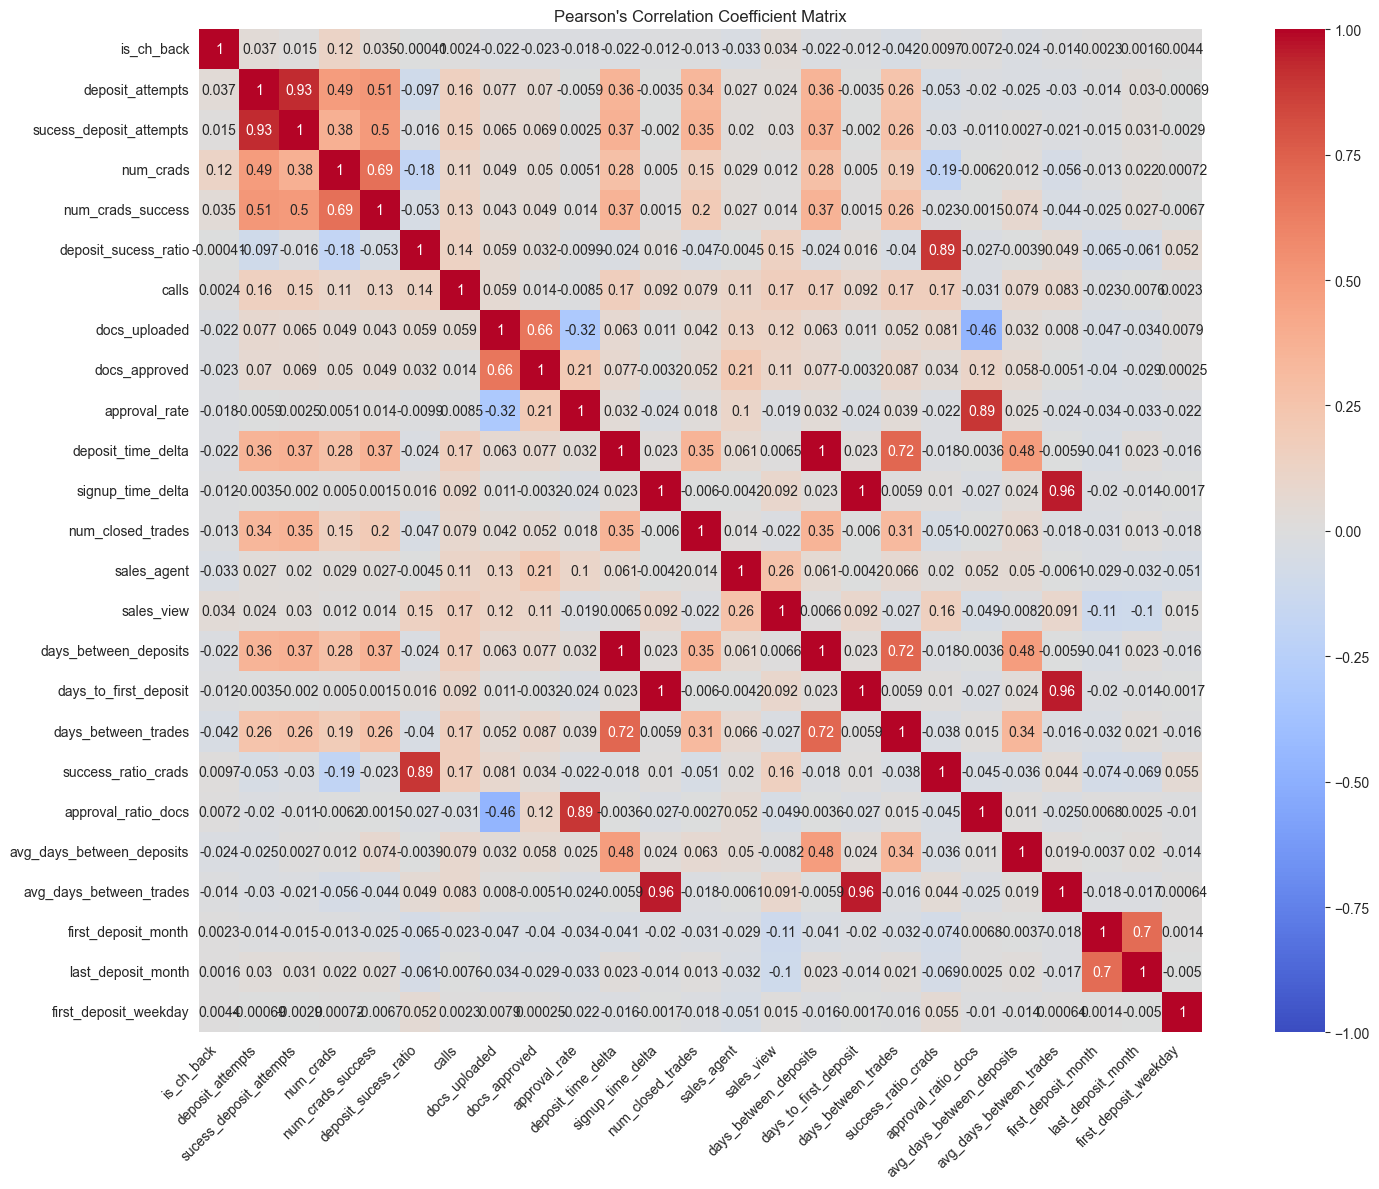

In [16]:

# Define features (after verifying the column names)
features = ['is_ch_back', 'deposit_attempts', 'sucess_deposit_attempts', 'num_crads', 'num_crads_success', 
            'deposit_sucess_ratio', 'calls', 'docs_uploaded', 'docs_approved', 'approval_rate', 
            'deposit_time_delta', 'signup_time_delta', 'num_closed_trades', 'sales_agent', 'sales_view', 
            'days_between_deposits', 'days_to_first_deposit', 'days_between_trades', 'success_ratio_crads', 
            'approval_ratio_docs', 'avg_days_between_deposits', 'avg_days_between_trades', 'first_deposit_month', 
            'last_deposit_month', 'first_deposit_weekday']

# Filter out the features that are actually present in the DataFrame
existing_features = [feature for feature in features if feature in df.columns]

# Calculate the Pearson's correlation matrix
correlation_matrix = df[existing_features].corr()

# Create a heatmap to display the correlation matrix
plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)

# Adjusting the labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.title("Pearson's Correlation Coefficient Matrix")
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()


### הצגת התפלגות הנתונים 

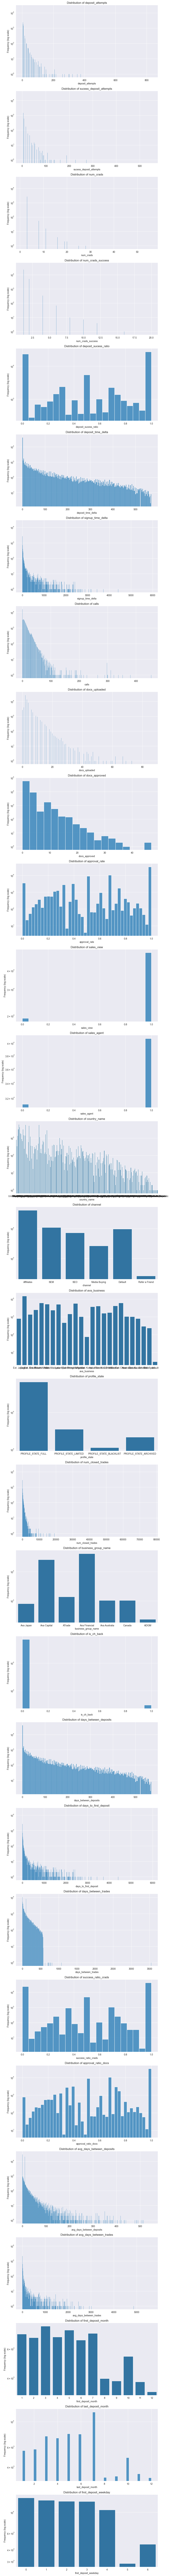

In [17]:

# Set the number of columns per row
columns_per_row = 1

# Calculate the number of required rows
num_rows = len(df.columns)

# Create subplots with one column per row
fig, axes = plt.subplots(nrows=num_rows, ncols=columns_per_row, figsize=(10, 5*num_rows))

# Plot histograms for numerical columns and bar plots for categorical columns
for i, column in enumerate(df.columns):
    if df[column].dtype == 'int64' or df[column].dtype == 'float64':
        sns.histplot(data=df, x=column, kde=False, ax=axes[i])
        axes[i].set_yscale('log')  # Set log scale for y-axis
    else:
        sns.countplot(data=df, x=column, ax=axes[i])
        axes[i].set_yscale('log')  # Set log scale for y-axis
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency (log scale)')

plt.tight_layout()
plt.show()


### הצגת התפלגות הנתונים לאחר חלוקה לפי הכשת עסקה

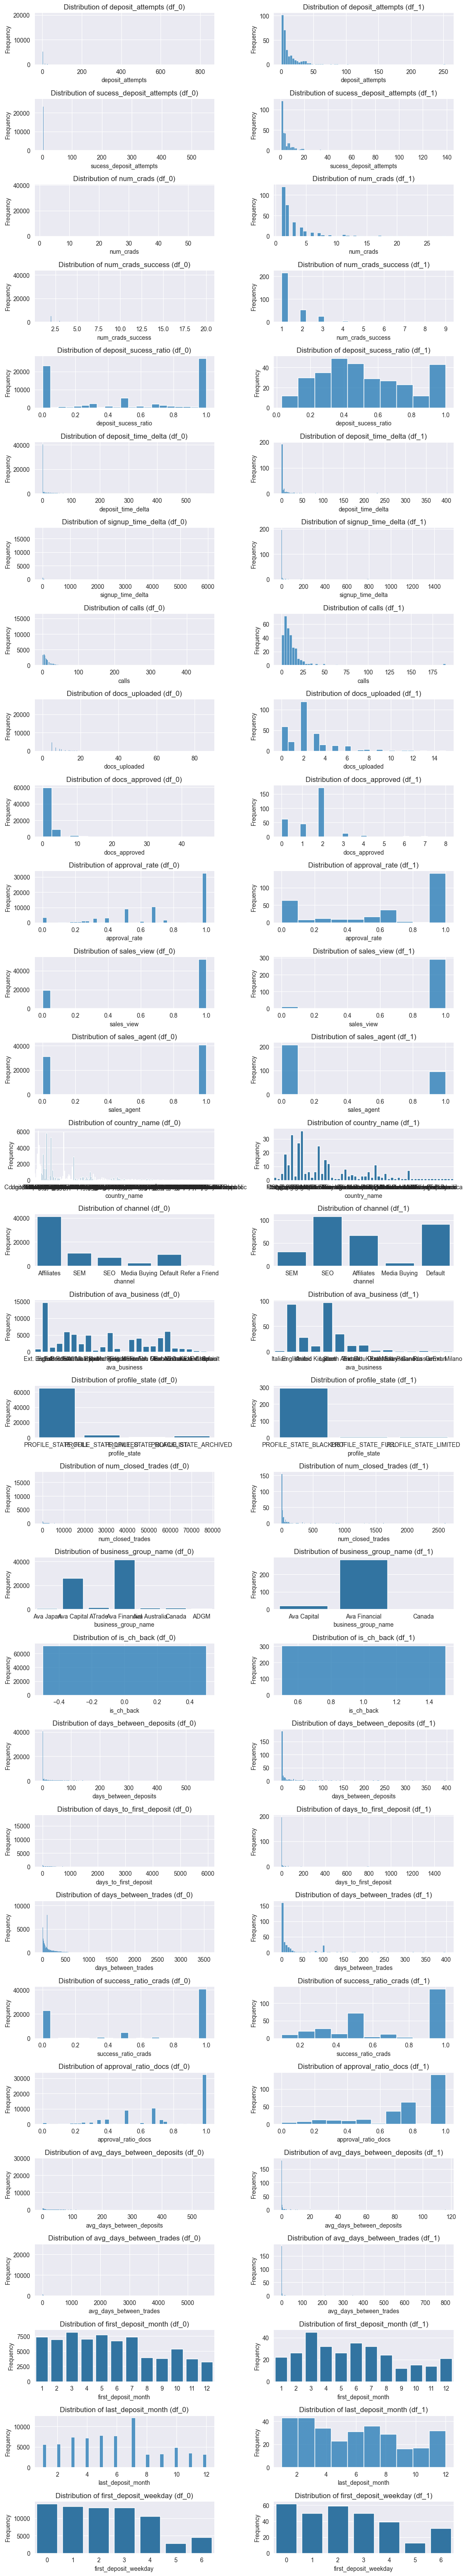

In [18]:

df_0 = df[df['is_ch_back'] == 0]
df_1 = df[df['is_ch_back'] == 1]


# Set the number of columns per row
columns_per_row = 1

# Calculate the number of required rows
num_rows = max(len(df_0.columns), len(df_1.columns))

# Create subplots with one row and two columns
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(11, 2*num_rows))  # Adjust the height as needed

# Set titles for the entire figure
#fig.suptitle('Distribution of Features for df_0 and df_1 ', fontsize=16)

# Plot histograms for numerical columns and bar plots for categorical columns for df_0
for i, column in enumerate(df_0.columns):
    if df_0[column].dtype == 'int64' or df_0[column].dtype == 'float64':
        sns.histplot(data=df_0, x=column, kde=False, ax=axes[i, 0])
    else:
        sns.countplot(data=df_0, x=column, ax=axes[i, 0])
   
    axes[i, 0].set_title(f'Distribution of {column} (df_0)')
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel('Frequency')

# Plot histograms for numerical columns and bar plots for categorical columns for df_1
for i, column in enumerate(df_1.columns):
    if df_1[column].dtype == 'int64' or df_1[column].dtype == 'float64':
        sns.histplot(data=df_1, x=column, kde=False, ax=axes[i, 1])
    else:
        sns.countplot(data=df_1, x=column, ax=axes[i, 1])
   
    axes[i, 1].set_title(f'Distribution of {column} (df_1)')
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


### ביצוע עיבוד לנתונים והכנה למודל כמו נרמול וערכים מספריים וקידוד חם לקטגוריילים 

In [19]:
# רשימת כל העמודות
cols = df.columns.tolist()

# הסרת עמודת היעד 'is_ch_back' מרשימת העמודות
cols = [c for c in cols if c not in ['is_ch_back']]

# הגדרת עמודת היעד
target = 'is_ch_back'

# הגדרת X ו-Y
X = df[cols]
Y = df[target]

# הגדרת StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

# ביצוע החלוקה לערכות אימון ובדיקה
for train_index, test_index in sss.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

# הצגת צורת הנתונים לאחר החלוקה
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("Test target distribution:\n", y_test.value_counts(normalize=True))


Train set shape: (57584, 29)
Test set shape: (14396, 29)
Train target distribution:
 is_ch_back
0    0.99578
1    0.00422
Name: proportion, dtype: float64
Test target distribution:
 is_ch_back
0    0.995763
1    0.004237
Name: proportion, dtype: float64


In [20]:

# המרת y_train לסוג float64
y_train = y_train.astype('float64')

# הפרדת נתונים מספריים ונתונים קטגוריים
X_numeric_train = X_train.select_dtypes(include=['int64', 'float64'])
X_numeric_test = X_test.select_dtypes(include=['int64', 'float64'])

# רשימת עמודות קטגוריות
categorical_columns = ['country_name', 'channel', 'ava_business', 'profile_state', 'business_group_name']
X_categorical_train = X_train[categorical_columns].astype(str)
X_categorical_test = X_test[categorical_columns].astype(str)

# קידוד נתונים קטגוריים
# OneHotEncoder משמש להמרת משתנים קטגוריים לווקטורים בינאריים.
# זה מאפשר למודלים של למידת מכונה להבין נתונים קטגוריים ולהשתמש בהם בצורה יעילה.
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_categorical_encoded_train = one_hot_encoder.fit_transform(X_categorical_train)
X_categorical_encoded_test = one_hot_encoder.transform(X_categorical_test)

# המרת התוצאה ל-DataFrame
X_categorical_encoded_train = pd.DataFrame(X_categorical_encoded_train, columns=one_hot_encoder.get_feature_names_out(categorical_columns))
X_categorical_encoded_test = pd.DataFrame(X_categorical_encoded_test, columns=one_hot_encoder.get_feature_names_out(categorical_columns))

# אחידות תכונות מספריות
# StandardScaler משמש לאחידות תכונות על ידי הסרת הממוצע והבאת הסטייה התקנית ל-1.
# זה חשוב כי זה מבטיח שכל תכונה תתרום שווה למודל.
scaler = StandardScaler()
X_numeric_scaled_train = scaler.fit_transform(X_numeric_train)
X_numeric_scaled_test = scaler.transform(X_numeric_test)

# המרת התכונות המספריות המאוחדות ל-DataFrame
X_numeric_scaled_train = pd.DataFrame(X_numeric_scaled_train, columns=X_numeric_train.columns)
X_numeric_scaled_test = pd.DataFrame(X_numeric_scaled_test, columns=X_numeric_test.columns)

# שילוב התכונות המספריות והקטגוריות
X_processed_train = pd.concat([X_numeric_scaled_train, X_categorical_encoded_train], axis=1)
X_processed_test = pd.concat([X_numeric_scaled_test, X_categorical_encoded_test], axis=1)


### OVER_SAMPEL איזון הדאטה בשיטת  

In [21]:
# Instantiate SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)

# Fit and resample
X_over, y_over = smote.fit_resample(X_processed_train, y_train)

X_processed_train = X_over
y_train = y_over 

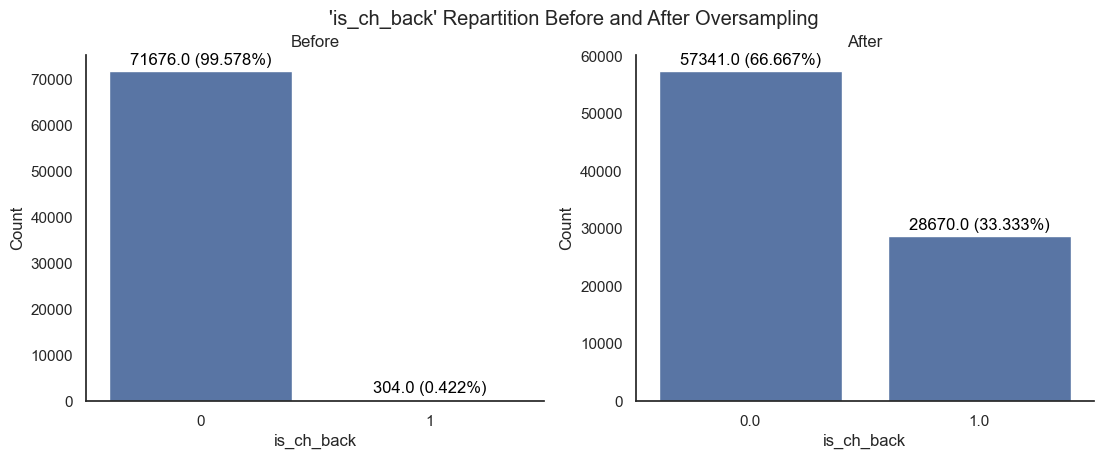

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style to white to remove background grids
sns.set(style="white")

# Assuming 'df' is your original DataFrame and 'y_train' is the Series after undersampling
fig, axs = plt.subplots(ncols=2, figsize=(13, 4.5))

# Plotting the distribution before undersampling
sns.countplot(x='is_ch_back', data=df, ax=axs[0])
axs[0].set_xlabel("is_ch_back")
axs[0].set_ylabel("Count")
sns.despine(ax=axs[0])

# Adding annotations on top of each bar
total_before = len(df)
for p in axs[0].patches:
    percentage = f'{100 * p.get_height() / total_before:.3f}%'
    axs[0].annotate(f'{p.get_height()} ({percentage})', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Converting y_train to DataFrame with the correct column name
y_train_df = y_train.to_frame(name='is_ch_back')

# Plotting the distribution after undersampling
sns.countplot(x='is_ch_back', data=y_train_df, ax=axs[1])
axs[1].set_xlabel("is_ch_back")
axs[1].set_ylabel("Count")
sns.despine(ax=axs[1])

# Adding annotations on top of each bar
total_after = len(y_train_df)
for p in axs[1].patches:
    percentage = f'{100 * p.get_height() / total_after:.3f}%'
    axs[1].annotate(f'{p.get_height()} ({percentage})', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')

fig.suptitle("'is_ch_back' Repartition Before and After Oversampling")
a1 = fig.axes[0]
a1.set_title("Before")
a2 = fig.axes[1]
a2.set_title("After")

plt.show()

### פונקציות לאימון המודל  ביצוע ולדיציה מציאת היפר פרמטרים והצגת התוצאות

In [23]:
# פונקציה לציור גרף ROC בקיפול מוצלב
def draw_roc_curve_k_fold(tpr_list, fpr_list, auc, pred_threshold=0.5):
    """
    פונקציה לציור גרף ROC בקיפול מוצלב.
    
    פרמטרים:
    tpr_list: רשימת ערכי TPR מכל קיפול.
    fpr_list: רשימת ערכי FPR מכל קיפול.
    auc: ערך ה-AUC הממוצע.
    pred_threshold: סף חיזוי (ברירת מחדל: 0.5).
    """
    mean_tpr = pd.DataFrame(tpr_list).mean()  
    mean_fpr = pd.DataFrame(fpr_list).mean() 
    std_tpr = pd.DataFrame(tpr_list).std()   
    std_fpr = pd.DataFrame(fpr_list).std() 
    
    plt.figure(figsize=(8, 8))
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='b', alpha=0.2, label='±1 std. dev.')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (10-Fold Cross-Validation)')
    plt.legend()
    plt.show()

# פונקציה לציור גרף חשיבות תכונות
def plot_feature_importance(mean_feature_importance, model_type, top_n=20, importance_type='Feature Importance'):
    """
    פונקציה לציור גרף חשיבות תכונות.
    
    פרמטרים:
    mean_feature_importance: סדרת ערכי חשיבות התכונות הממוצעים.
    model_type: סוג המודל.
    top_n: מספר התכונות המובילות להצגה (ברירת מחדל: 20).
    importance_type: סוג החשיבות (ברירת מחדל: 'Feature Importance').
    """
    top_features = mean_feature_importance.head(top_n)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=top_features.values, y=top_features.index)
    plt.xlabel('Mean Importance')
    plt.ylabel('Features')
    plt.title(f'Top {top_n} {importance_type} for {model_type}')
    plt.show()

# פונקציה להערכת ביצועי המודל
def evaluate_model(y_test, y_pred, y_probabilities, cm):
    """
    פונקציה להערכת ביצועי המודל.
    
    פרמטרים:
    y_test: ערכי היעד האמיתיים.
    y_pred: ערכי היעד החזויים.
    y_probabilities: הסתברויות החיזוי של המודל.
    cm: מטריצת בלבול.
    
    מחזירה:
    precision, recall, specificity, f1, accuracy, auc, fpr, tpr
    """
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    specificity = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_probabilities)
    fpr, tpr, _ = roc_curve(y_test, y_probabilities)
    return precision, recall, specificity, f1, accuracy, auc, fpr, tpr

# פונקציה ליצירת מודל רשת נוירונים
def create_nn_model(optimizer='adam', dropout_rate=0.2):
    """
    פונקציה ליצירת מודל רשת נוירונים.
    
    פרמטרים:
    optimizer: סוג האופטימיזטור (ברירת מחדל: 'adam').
    dropout_rate: שיעור ה-Dropout (ברירת מחדל: 0.2).
    
    מחזירה:
    אובייקט של מודל רשת נוירונים מאומן.
    """
    model = Sequential()
    model.add(Dense(32, input_shape=(X_processed_train.shape[1],), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# פונקציה ליצירת מודל קלאסי
def create_model(model_type, class_weights, best_params=None):
    """
    פונקציה ליצירת מודל קלאסי.
    
    פרמטרים:
    model_type: סוג המודל.
    class_weights: משקלים למחלקות.
    best_params: פרמטרים אופטימליים למודל (ברירת מחדל: None).
    
    מחזירה:
    אובייקט של המודל הנבחר מאומן.
    """
    classifiers = {
        "AdaBoost": AdaBoostClassifier(random_state=120, algorithm='SAMME'),
        "RandomForest": RandomForestClassifier(random_state=42, class_weight=class_weights),
        "GradientBoost": GradientBoostingClassifier(random_state=120),
        "DecisionTree": DecisionTreeClassifier(random_state=120, class_weight=class_weights),
        "LogisticRegression": LogisticRegression(random_state=120),
        "HistGradientBoost": HistGradientBoostingClassifier(random_state=120)
    }
    classifier = classifiers[model_type]
    if best_params:
        classifier.set_params(**best_params)
    return classifier
def search_hyperparameters(X, y, k, model_type, class_weights, pred_threshold, dropout_rate):
    """
    פונקציה לחיפוש היפר-פרמטרים אופטימליים עבור המודל הנתון.
    
    פרמטרים:
    X: תכונות הקלט.
    y: תוויות היעד.
    k: מספר הקיפולים בקיפול מוצלב.
    model_type: סוג המודל.
    class_weights: משקלים למחלקות.
    pred_threshold: סף חיזוי.
    dropout_rate: שיעור ה-Dropout עבור רשתות נוירונים.
    
    מחזירה:
    היפר-פרמטרים אופטימליים ורשימות של תוצאות מדדים שונים לכל קיפול.
    """
    param_grids = {
        "RandomForest": {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        },
        "AdaBoost": {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1, 1]
        },
        "GradientBoost": {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1, 1],
            'max_depth': [3, 5, 10]
        },
        "DecisionTree": {
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        },
        "LogisticRegression": {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2']
        },
        "HistGradientBoost": {
            'learning_rate': [0.01, 0.1, 1],
            'max_iter': [100, 200],
            'max_depth': [None, 10, 20]
        },
        "NeuralNetwork": {
            'batch_size': [5, 15, 25],
            'epochs': [5, 10, 16],
            'optimizer': ['adam', 'rmsprop']
        }
    }

    recall_scorer = make_scorer(recall_score)

    if model_type == "NeuralNetwork":
        best_score = 0
        best_params = {}
        TP, TN, FP, FN = [], [], [], []
        precision, recall, specificity, f1, accuracy, AUC = [], [], [], [], [], []
        tpr_list, fpr_list = [], []

        # קיפול מוצלב עבור רשתות נוירונים
        for batch_size in param_grids['NeuralNetwork']['batch_size']:
            for epochs in param_grids['NeuralNetwork']['epochs']:
                for optimizer in param_grids['NeuralNetwork']['optimizer']:
                    rskf = RepeatedStratifiedKFold(n_splits=k, n_repeats=1, random_state=78)
                    for train_index, test_index in rskf.split(X, y):
                        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                        # יצירת מודל רשת נוירונים
                        model = create_nn_model(optimizer=optimizer, dropout_rate=dropout_rate)
                        model.fit(X_train.values, y_train.values, batch_size=batch_size, epochs=epochs, verbose=0)
                        y_probabilities = model.predict(X_test.values)
                        y_pred = (y_probabilities >= pred_threshold).astype(int)

                        cm = confusion_matrix(y_test, y_pred)
                        TP.append(cm[1][1])
                        TN.append(cm[0][0])
                        FN.append(cm[0][1])
                        FP.append(cm[1][0])

                        # הערכת המודל והוספת תוצאות לרשימות
                        prec, rec, spec, f1_score, acc, auc, fpr, tpr = evaluate_model(y_test, y_pred, y_probabilities, cm)
                        precision.append(prec)
                        recall.append(rec)
                        specificity.append(spec)
                        f1.append(f1_score)
                        accuracy.append(acc)
                        AUC.append(auc)
                        tpr_list.append(tpr)
                        fpr_list.append(fpr)

                        # עדכון הפרמטרים הטובים ביותר
                        recall_current = recall_score(y_test, y_pred)
                        if recall_current > best_score:
                            best_score = recall_current
                            best_params = {'batch_size': batch_size, 'epochs': epochs, 'optimizer': optimizer}

        return best_params, TP, TN, FP, FN, precision, recall, specificity, f1, accuracy, AUC, tpr_list, fpr_list, None
    else:
        TP, TN, FP, FN = [], [], [], []
        precision, recall, specificity, f1, accuracy, AUC = [], [], [], [], [], []
        tpr_list, fpr_list = [], []
        best_params_list = []
        feature_importance_dict = {'features': list(X.columns)}

        rskf = RepeatedStratifiedKFold(n_splits=k, n_repeats=1, random_state=78)
        for train_index, test_index in rskf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # חיפוש היפר-פרמטרים באמצעות GridSearchCV
            grid_search = GridSearchCV(estimator=create_model(model_type, class_weights), param_grid=param_grids[model_type], cv=k, scoring=recall_scorer, n_jobs=-1)
            grid_search.fit(X_train, y_train)
            best_classifier = grid_search.best_estimator_
            best_params_list.append(grid_search.best_params_)
            y_probabilities = best_classifier.predict_proba(X_test)[:, 1]
            y_pred = (y_probabilities >= pred_threshold).astype(int)

            cm = confusion_matrix(y_test, y_pred)
            TP.append(cm[1][1])
            TN.append(cm[0][0])
            FN.append(cm[0][1])
            FP.append(cm[1][0])

            # הערכת המודל והוספת תוצאות לרשימות
            prec, rec, spec, f1_score, acc, auc, fpr, tpr = evaluate_model(y_test, y_pred, y_probabilities, cm)
            precision.append(prec)
            recall.append(rec)
            specificity.append(spec)
            f1.append(f1_score)
            accuracy.append(acc)
            AUC.append(auc)
            tpr_list.append(tpr)
            fpr_list.append(fpr)

            # הוספת חשיבות התכונות במידת האפשר
            if model_type in ["RandomForest", "GradientBoost", "DecisionTree"]:
                feature_importances = best_classifier.feature_importances_
                feature_importance_dict[str(train_index)] = feature_importances
            else:
                result = permutation_importance(best_classifier, X_test, y_test, n_repeats=2, random_state=42)
                feature_importance_dict['permutation_importance'] = result.importances_mean

        # הצגת חשיבות התכונות
        if model_type not in ["LogisticRegression", "HistGradientBoost", "NeuralNetwork"]:
            feature_importance_df = pd.DataFrame(feature_importance_dict)
            mean_feature_importance = feature_importance_df.set_index(['features']).transpose().mean()
            mean_feature_importance = mean_feature_importance.sort_values(ascending=False)
            plot_feature_importance(mean_feature_importance, model_type, importance_type='Feature Importance')
        else:
            mean_feature_importance = pd.Series(feature_importance_dict['permutation_importance'], index=X.columns).sort_values(ascending=False)
            plot_feature_importance(mean_feature_importance, model_type, importance_type='Permutation Importance')

        return best_params_list[-1], TP, TN, FP, FN, precision, recall, specificity, f1, accuracy, AUC, tpr_list, fpr_list, mean_feature_importance


def k_cross_validation(X, y, model_type, k=10, class_weights={0: 1540, 1: 389}, pred_threshold=0.5, dropout_rate=0.2):
    """
    פונקציה לביצוע קיפול מוצלב עם חיפוש היפר-פרמטרים ואימון מחדש על כל סט האימון.
    
    פרמטרים:
    X: תכונות הקלט.
    y: תוויות היעד.
    model_type: סוג המודל.
    k: מספר הקיפולים בקיפול מוצלב (ברירת מחדל: 10).
    class_weights: משקלים למחלקות (ברירת מחדל: {0: 1540, 1: 389}).
    pred_threshold: סף חיזוי (ברירת מחדל: 0.5).
    dropout_rate: שיעור ה-Dropout עבור רשתות נוירונים (ברירת מחדל: 0.2).
    
    מחזירה:
    DataFrame עם תוצאות הקיפול המוצלב וחשיבות התכונות.
    """
    best_params, TP, TN, FP, FN, precision, recall, specificity, f1, accuracy, AUC, tpr_list, fpr_list, mean_feature_importance = search_hyperparameters(X, y, k, model_type, class_weights, pred_threshold, dropout_rate)

    results = pd.DataFrame({
        "TP": TP, "TN": TN, "FN": FN, "FP": FP, "Recall": recall,
        "Specificity": specificity, "Precision": precision, "F1-score": f1,
        "Accuracy": accuracy, "AUC": AUC
    })

    mean_recall_fold_results = results['Recall'].mean()
    std_recall_fold_results = results['Recall'].std()

    print(f"Mean Recall from fold results: {mean_recall_fold_results}")
    print(f"Standard Deviation Recall from fold results: {std_recall_fold_results}")

    df = pd.DataFrame({"mean": results.mean().round(decimals=4), "sd": results.std().round(decimals=3)})
    draw_roc_curve_k_fold(tpr_list, fpr_list, mean_recall_fold_results)

    # אימון המודל הטוב ביותר על כל סט האימון
    if model_type == "NeuralNetwork":
        model = create_nn_model(optimizer=best_params['optimizer'], dropout_rate=dropout_rate)
        model.fit(X.values, y.values, batch_size=best_params['batch_size'], epochs=best_params['epochs'], verbose=0)
    else:
        model = create_model(model_type, class_weights, best_params)
        model.fit(X, y)

    # הערכת המודל על סט המבחן
    y_probabilities = model.predict_proba(X_processed_test)[:, 1] if model_type != "NeuralNetwork" else model.predict(X_processed_test.values)
    y_pred = (y_probabilities >= pred_threshold).astype(int)
    
    cm = confusion_matrix(y_test, y_pred)
    precision, recall, specificity, f1, accuracy, auc, fpr, tpr = evaluate_model(y_test, y_pred, y_probabilities, cm)
    
    print(f"Confusion Matrix:\n{cm}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Specificity: {specificity}")
    print(f"F1-score: {f1}")
    print(f"Accuracy: {accuracy}")
    print(f"AUC: {auc}")

    return df, mean_feature_importance ,best_params
class_weights = {0:1540, 1:389}

### RECALL החזרת תוצאות אחרי אימון עם אופטימזיציה לפי שיטת 

### DecisionTreeCLassifier

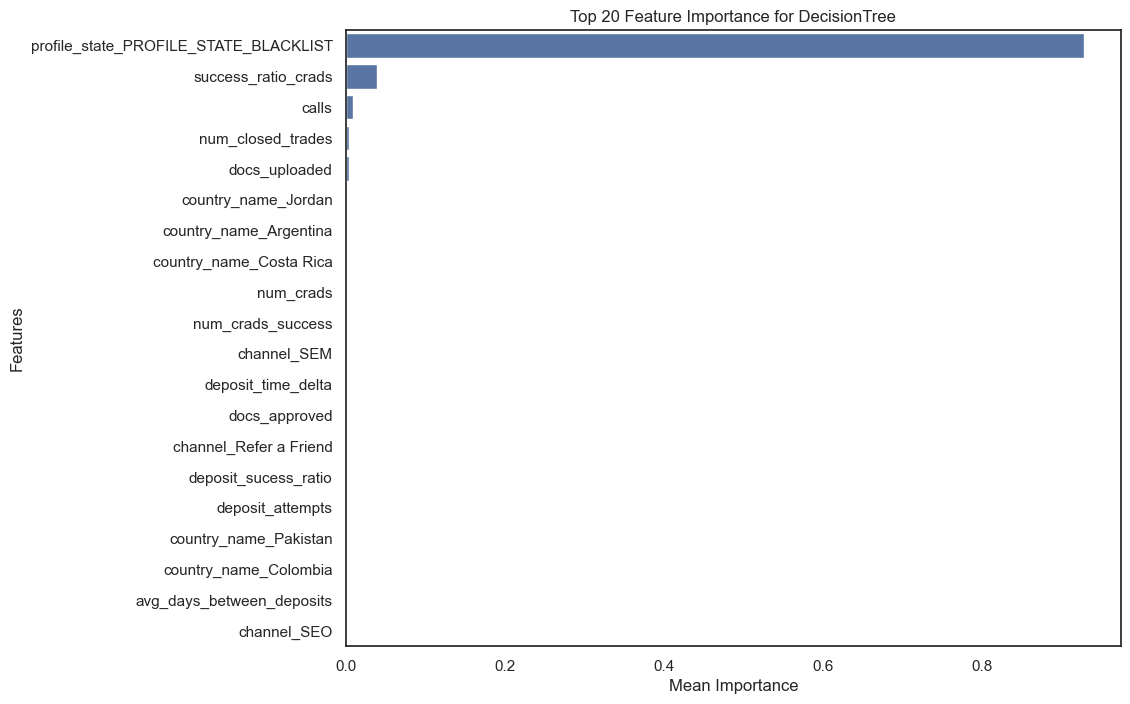

Mean Recall from fold results: 0.9975235437739798
Standard Deviation Recall from fold results: 0.0021444612694718167


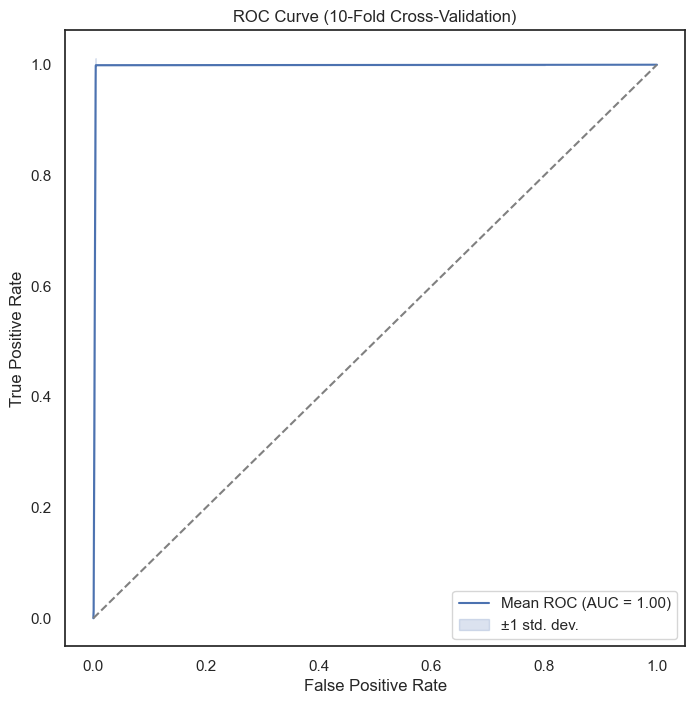

Confusion Matrix:
[[14273    62]
 [    5    56]]
Precision: 0.4745762711864407
Recall: 0.9180327868852459
Specificity: 0.9956749215207534
F1-score: 0.6256983240223464
Accuracy: 0.9953459294248402
AUC: 0.9729533927621836


,mean,sd
TP,5719.8000,12.296
TN,11420.4000,9.236
FN,47.8000,8.871
FP,14.2000,12.296
Recall,0.9975,0.002
Specificity,0.9958,0.001
Precision,0.9917,0.002
F1-score,0.9946,0.001
Accuracy,0.9964,0.000
AUC,0.9973,0.000


In [24]:

dt_results_, dt_feature_importance , best_params_dt= k_cross_validation(X_processed_train,y_train, model_type="DecisionTree", k= 5 , class_weights=class_weights, pred_threshold=0.5)
dt_results_


### AdaBoostClassifier

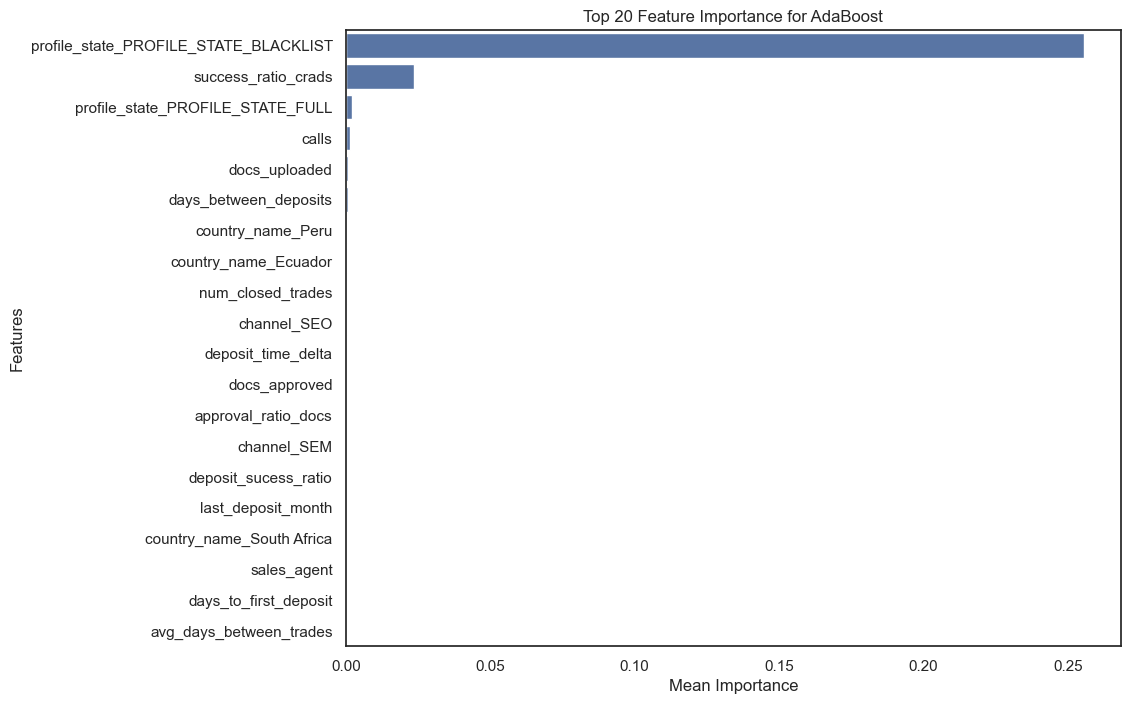

Mean Recall from fold results: 0.9981513777467736
Standard Deviation Recall from fold results: 0.0008418220011264112


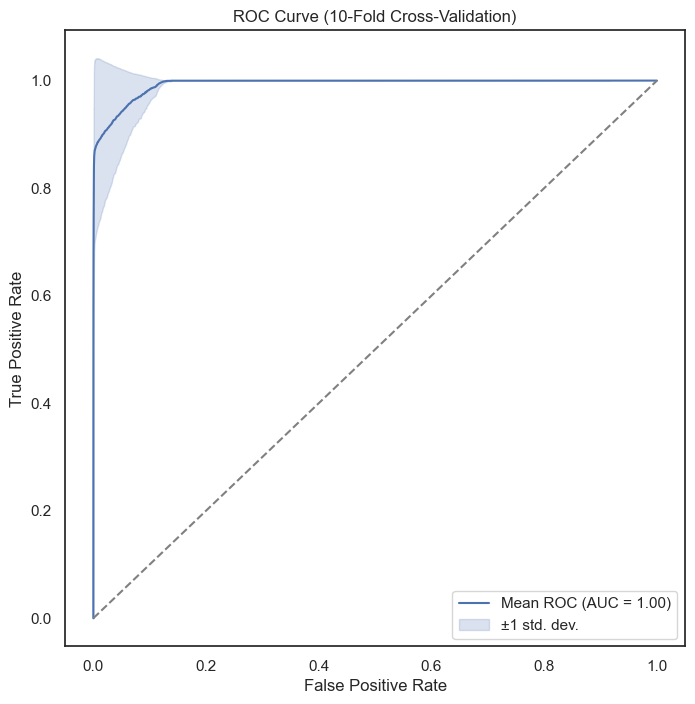

Confusion Matrix:
[[14254    81]
 [    5    56]]
Precision: 0.40875912408759124
Recall: 0.9180327868852459
Specificity: 0.9943494942448553
F1-score: 0.5656565656565656
Accuracy: 0.9940261183662128
AUC: 0.9977516910919622


,mean,sd
TP,5723.4000,4.827
TN,11404.8000,7.918
FN,63.4000,7.635
FP,10.6000,4.827
Recall,0.9982,0.001
Specificity,0.9945,0.001
Precision,0.9890,0.001
F1-score,0.9936,0.001
Accuracy,0.9957,0.001
AUC,0.9996,0.000


In [25]:

ab_results, ab_feature_importance , best_params_ab = k_cross_validation(X_processed_train,y_train, model_type="AdaBoost", k=5, class_weights=class_weights, pred_threshold=0.5)
ab_results


### RandomForestClassifier

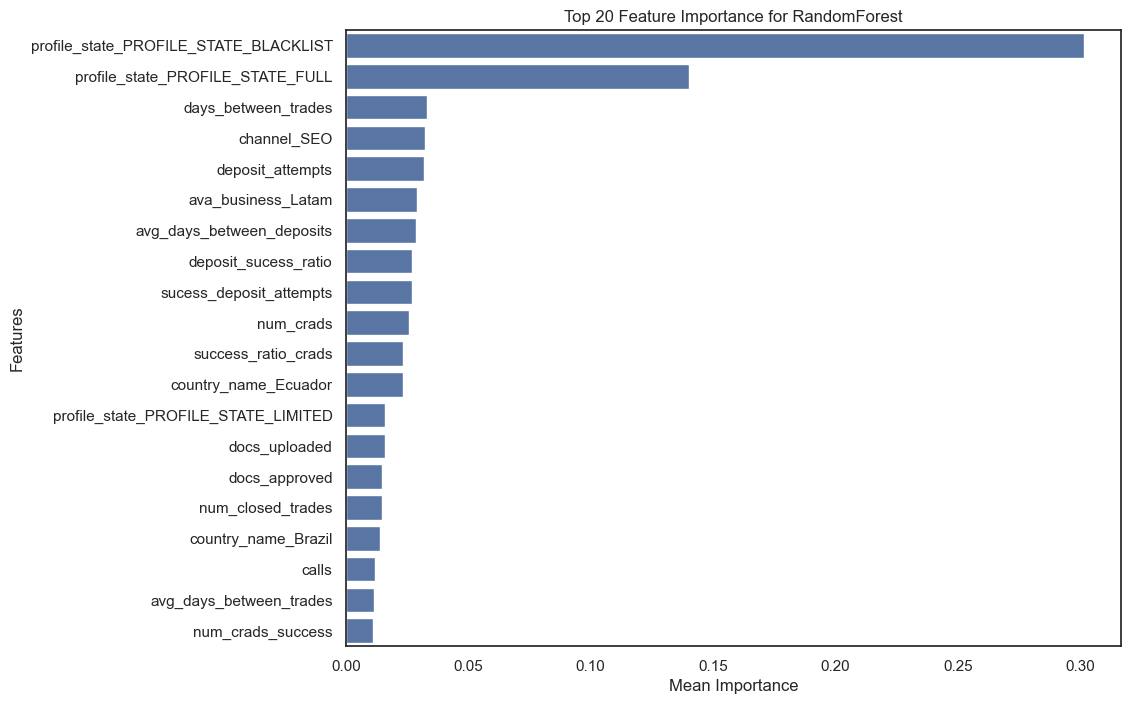

Mean Recall from fold results: 0.9992675270317406
Standard Deviation Recall from fold results: 0.00041637029599977363


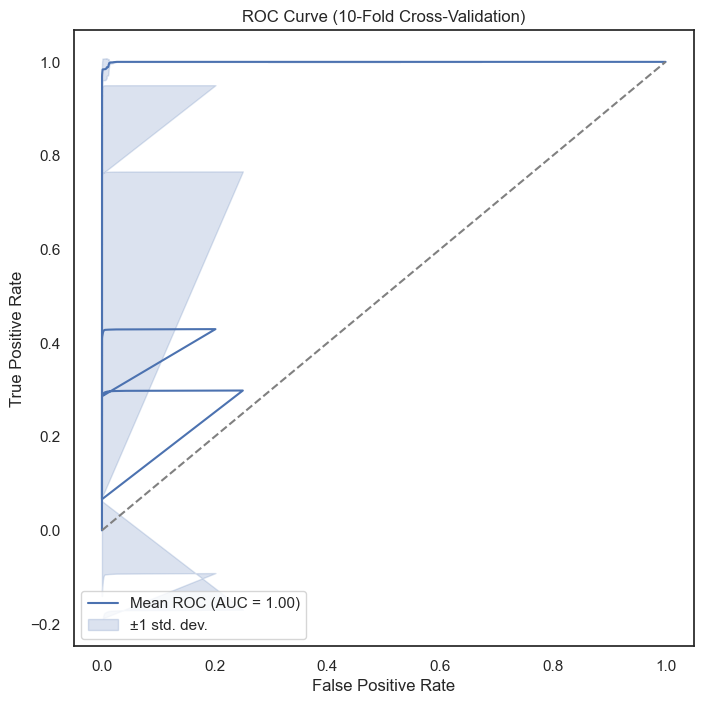

Confusion Matrix:
[[14315    20]
 [   21    40]]
Precision: 0.6666666666666666
Recall: 0.6557377049180327
Specificity: 0.9986048133937914
F1-score: 0.6611570247933884
Accuracy: 0.9971519866629619
AUC: 0.9981084929125664


,mean,sd
TP,5729.8000,2.387
TN,11445.6000,4.879
FN,22.6000,4.615
FP,4.2000,2.387
Recall,0.9993,0.000
Specificity,0.9980,0.000
Precision,0.9961,0.001
F1-score,0.9977,0.000
Accuracy,0.9984,0.000
AUC,1.0000,0.000


In [26]:
rf_results, rf_feature_importance , best_params_rf = k_cross_validation(X_processed_train,y_train, model_type="RandomForest", k=5, class_weights=class_weights, pred_threshold=0.5)
rf_results


### GradientBoostingClassifier

In [27]:
#gb_results, dt_feature_importance = k_cross_validation(X_processed_train,y_train, model_type="GradientBoost", k=5, class_weights=class_weights, pred_threshold=0.5)
#gb_results


### LogisticRegression

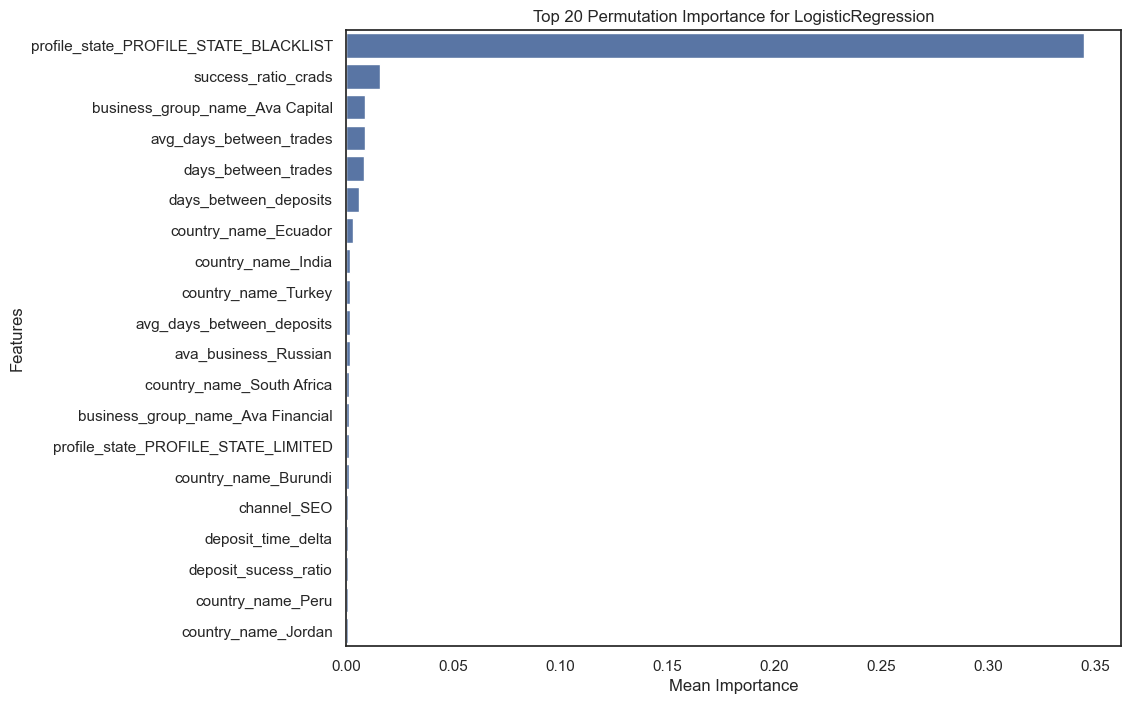

Mean Recall from fold results: 0.9976630624346006
Standard Deviation Recall from fold results: 0.001100230924003277


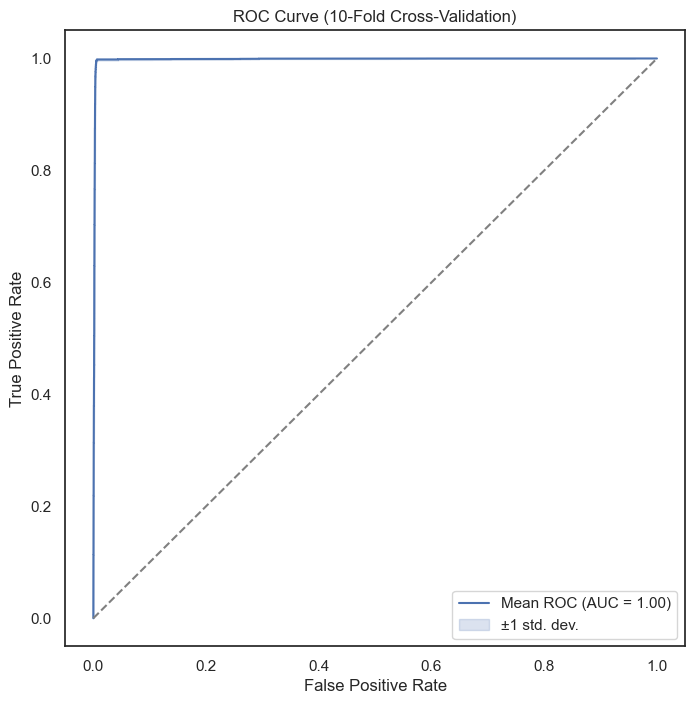

Confusion Matrix:
[[14238    97]
 [    7    54]]
Precision: 0.3576158940397351
Recall: 0.8852459016393442
Specificity: 0.9932333449598884
F1-score: 0.5094339622641509
Accuracy: 0.9927757710475132
AUC: 0.9965291874181614


,mean,sd
TP,5720.6000,6.309
TN,11397.4000,7.127
FN,70.8000,6.797
FP,13.4000,6.309
Recall,0.9977,0.001
Specificity,0.9938,0.001
Precision,0.9878,0.001
F1-score,0.9927,0.001
Accuracy,0.9951,0.001
AUC,0.9985,0.000


In [28]:
lr_results, lr_feature_importance  , best_params_lr= k_cross_validation(X_processed_train,y_train, model_type="LogisticRegression", k=5, class_weights=class_weights, pred_threshold=0.5)
lr_results


### HistGradientBoostingClassifier

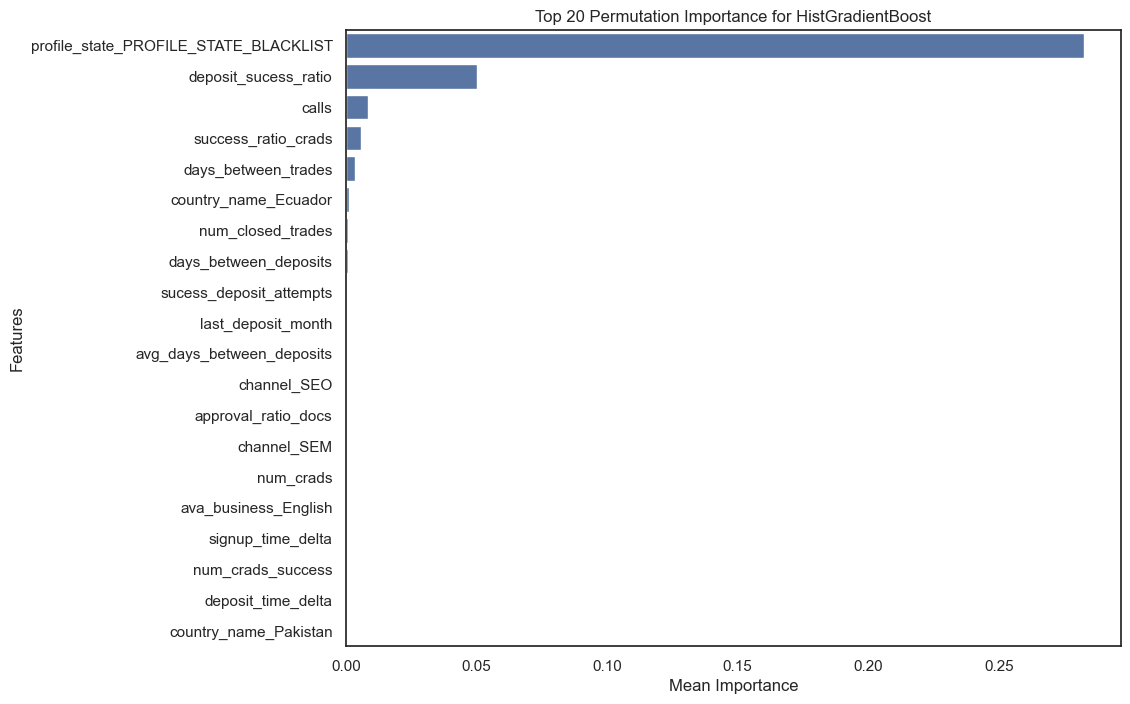

Mean Recall from fold results: 0.9993372863620508
Standard Deviation Recall from fold results: 0.0002273875969725426


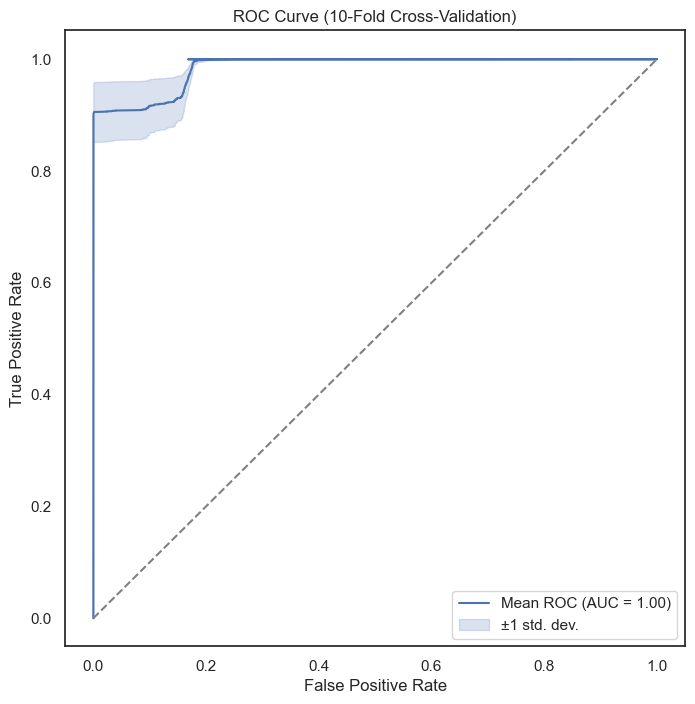

Confusion Matrix:
[[14307    28]
 [   11    50]]
Precision: 0.6410256410256411
Recall: 0.819672131147541
Specificity: 0.998046738751308
F1-score: 0.7194244604316546
Accuracy: 0.9972909141428175
AUC: 0.996060313230829


,mean,sd
TP,5730.2000,1.304
TN,11445.2000,5.718
FN,23.0000,5.385
FP,3.8000,1.304
Recall,0.9993,0.000
Specificity,0.9980,0.000
Precision,0.9960,0.001
F1-score,0.9977,0.001
Accuracy,0.9984,0.000
AUC,1.0000,0.000


In [43]:
hgb_results, hgb_feature_importance , best_params_hgb = k_cross_validation(X_processed_train,y_train, model_type="HistGradientBoost", k=5, class_weights=class_weights, pred_threshold=0.5)
hgb_results


### Sequential NN

538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 959us/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 883us/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 970us/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 945us/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 838us/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step
538/538 ━━━━━━━━━━━━━

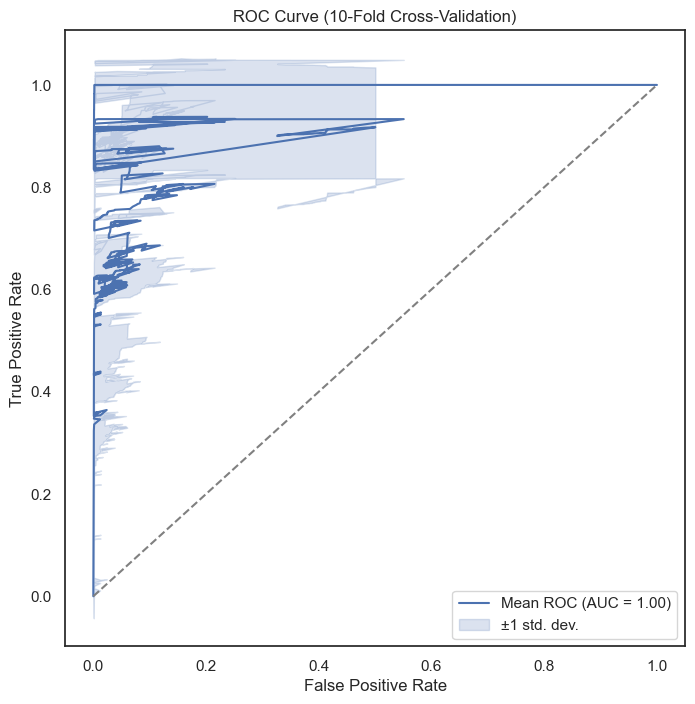

450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
Confusion Matrix:
[[14285    50]
 [   16    45]]
Precision: 0.47368421052631576
Recall: 0.7377049180327869
Specificity: 0.9965120334844786
F1-score: 0.5769230769230769
Accuracy: 0.995415393164768
AUC: 0.9952386398074184


,mean,sd
TP,5730.9667,5.267
TN,11420.3444,17.954
FN,47.8556,17.854
FP,3.0333,5.267
Recall,0.9995,0.001
Specificity,0.9958,0.002
Precision,0.9917,0.003
F1-score,0.9956,0.002
Accuracy,0.9970,0.001
AUC,0.9987,0.001


In [44]:
# קריאה לפונקציה עם כל הנתונים עבור רשתות נוירונים
nn_results, nn_feature_importance , best_params_nn= k_cross_validation(X_processed_train, y_train, model_type="NeuralNetwork", k=5, class_weights=class_weights, pred_threshold=0.5)
(nn_results)


## מודל היברידי משולב

In [45]:
def evaluate_voting_classifier_cv(X, y, k, class_weights, best_params_rf, best_params_hgb, best_params_lr):
    # הגדרת המודלים השונים
    clf1 = RandomForestClassifier(random_state=42, class_weight=class_weights, **best_params_rf)
    clf2 = HistGradientBoostingClassifier(random_state=42, **best_params_hgb)
    clf3 = LogisticRegression(random_state=42, **best_params_lr)

    # יצירת Voting Classifier
    voting_clf = VotingClassifier(estimators=[
        ('rf', clf1), 
        ('hgb', clf2), 
        ('lr', clf3)
    ], voting='soft')

    # Lists to hold the results
    TP, TN, FP, FN = [], [], [], []
    precision, recall, specificity, f1, accuracy, AUC = [], [], [], [], [], []
    tpr_list, fpr_list = [], []

    rskf = RepeatedStratifiedKFold(n_splits=k, n_repeats=1, random_state=78)
    for train_index, test_index in rskf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # אימון ה-Voting Classifier על כל סט האימון
        voting_clf.fit(X_train, y_train)

        # הערכת המודל על סט הבדיקה
        y_pred = voting_clf.predict(X_test)
        y_prob = voting_clf.predict_proba(X_test)[:, 1]

        # חישוב המדדים השונים
        precision_score, recall_score, specificity_score, f1_score, accuracy_score, auc, fpr, tpr = evaluate_model(y_test, y_pred, y_prob, confusion_matrix(y_test, y_pred))

        # Append the scores
        precision.append(precision_score)
        recall.append(recall_score)
        specificity.append(specificity_score)
        f1.append(f1_score)
        accuracy.append(accuracy_score)
        AUC.append(auc)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        cm = confusion_matrix(y_test, y_pred)
        TN.append(cm[0][0])
        FP.append(cm[0][1])
        FN.append(cm[1][0])
        TP.append(cm[1][1])

    results = pd.DataFrame({
        "TP": TP, "TN": TN, "FN": FN, "FP": FP, "Recall": recall,
        "Specificity": specificity, "Precision": precision, "F1-score": f1,
        "Accuracy": accuracy, "AUC": AUC
    })

    mean_recall_fold_results = results['Recall'].mean()
    std_recall_fold_results = results['Recall'].std()

    df = pd.DataFrame({"mean": results.mean().round(decimals=4), "sd": results.std().round(decimals=3)})

    return df

# דוגמה לשימוש בפונקציה
voting_results = evaluate_voting_classifier_cv(X_processed_train, y_train, k=2, class_weights=class_weights, best_params_rf=best_params_rf, best_params_hgb=best_params_hgb, best_params_lr=best_params_lr)
(voting_results)


,mean,sd
TP,14331.5000,0.707
TN,28571.0000,5.657
FN,3.5000,0.707
FP,99.5000,4.950
Recall,0.9998,0.000
Specificity,0.9965,0.000
Precision,0.9931,0.000
F1-score,0.9964,0.000
Accuracy,0.9976,0.000
AUC,1.0000,0.000


### איחוד התוצאות לטבלה מסכמת

In [46]:
# קיבוץ התוצאות לטבלה אחת
models = {
    'AdaBoost': ab_results,
    'RandomForest': rf_results,
    'DecisionTree': dt_results_,
    'LogisticRegression': lr_results,
    'HistGradientBoost': hgb_results,
    'Sequential_NN': nn_results,
    'Voting_CR': voting_results
}

combined_results = pd.DataFrame()

for model_name, results in models.items():
    # יצירת tuple של (mean, sd)
    results['Metric'] = results.index
    results['Model'] = model_name
    results['Mean_SD'] = list(zip(results['mean'], results['sd']))
    combined_results = pd.concat([combined_results, results[['Metric', 'Model', 'Mean_SD']]])

# יצירת טבלת pivot
combined_results_pivot = combined_results.pivot(index='Metric', columns='Model', values='Mean_SD')

# המרת הטבלה חזרה ל-DataFrame
final_df = pd.DataFrame(combined_results_pivot.to_records())

# הסרת האינדקסים והסדר הנכון של העמודות
final_df.columns = [col.replace("('", "").replace("', '')", "") for col in final_df.columns]

# הסרת האינדקסים המספריים
final_df = final_df.reset_index(drop=True)

# סידור העמודות לפי הסדר הרצוי
metrics_order = ["TN", "TP", "FN", "FP", "AUC", "Accuracy", "F1-score", "Precision", "Recall", "Specificity"]
final_df['Metric'] = pd.Categorical(final_df['Metric'], categories=metrics_order, ordered=True)
final_df = final_df.sort_values('Metric').reset_index(drop=True)

# הגדרת Metric כאינדקס
final_df.set_index('Metric', inplace=True)


In [47]:
# פונקציה לחישוב ממוצע וסטיית תקן
def calculate_mean_sd(row):
    means = []
    sds = []
    for model in row.index:
        if model != 'Mean_SD_Summary':
            mean, sd = row[model]
            means.append(mean)
            sds.append(sd)
    mean_summary = round(pd.Series(means).mean(), 3)
    sd_summary = round(pd.Series(sds).std(), 3)
    return (mean_summary, sd_summary)


# הוספת העמודה המסכמת
final_df['Mean_SD_Summary'] = final_df.apply(calculate_mean_sd, axis=1)
final_df

,AdaBoost,DecisionTree,HistGradientBoost,LogisticRegression,RandomForest,Sequential_NN,Voting_CR,Mean_SD_Summary
Metric,,,,,,,,
TN,"(11404.8, 7.918)","(11420.4, 9.236)","(11445.2, 5.718)","(11397.4, 7.127)","(11445.6, 4.879)","(11420.3444, 17.954)","(28571.0, 5.657)","(13872.106, 4.489)"
TP,"(5723.4, 4.827)","(5719.8, 12.296)","(5730.2, 1.304)","(5720.6, 6.309)","(5729.8, 2.387)","(5730.9667, 5.267)","(14331.5, 0.707)","(6955.181, 3.946)"
FN,"(63.4, 7.635)","(47.8, 8.871)","(23.0, 5.385)","(70.8, 6.797)","(22.6, 4.615)","(47.8556, 17.854)","(3.5, 0.707)","(39.851, 5.299)"
FP,"(10.6, 4.827)","(14.2, 12.296)","(3.8, 1.304)","(13.4, 6.309)","(4.2, 2.387)","(3.0333, 5.267)","(99.5, 4.95)","(21.248, 3.53)"
AUC,"(0.9996, 0.0)","(0.9973, 0.0)","(1.0, 0.0)","(0.9985, 0.0)","(1.0, 0.0)","(0.9987, 0.001)","(1.0, 0.0)","(0.999, 0.0)"
Accuracy,"(0.9957, 0.001)","(0.9964, 0.0)","(0.9984, 0.0)","(0.9951, 0.001)","(0.9984, 0.0)","(0.997, 0.001)","(0.9976, 0.0)","(0.997, 0.001)"
F1-score,"(0.9936, 0.001)","(0.9946, 0.001)","(0.9977, 0.001)","(0.9927, 0.001)","(0.9977, 0.0)","(0.9956, 0.002)","(0.9964, 0.0)","(0.995, 0.001)"
Precision,"(0.989, 0.001)","(0.9917, 0.002)","(0.996, 0.001)","(0.9878, 0.001)","(0.9961, 0.001)","(0.9917, 0.003)","(0.9931, 0.0)","(0.992, 0.001)"
Recall,"(0.9982, 0.001)","(0.9975, 0.002)","(0.9993, 0.0)","(0.9977, 0.001)","(0.9993, 0.0)","(0.9995, 0.001)","(0.9998, 0.0)","(0.999, 0.001)"


### אימון המודל שנבחר והצגת תוצאות

In [48]:
# הגדרת הפרמטרים הטובים ביותר עבור המודל
best_params = best_params_hgb

# אימון המודל הסופי עם הפרמטרים הטובים ביותר על כל סט האימון
final_model = HistGradientBoostingClassifier(
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    max_iter=best_params['max_iter'],
    random_state=120
)
final_model.fit(X_processed_train, y_train)

# ביצוע ניבוי על סט הבדיקה
y_probabilities = final_model.predict_proba(X_processed_test)[:, 1]
y_pred = (y_probabilities >= 0.5).astype(int)

# חישוב המדדים השונים
cm = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred)
specificity = recall_score(y_test, y_pred, pos_label=0)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_probabilities)
fpr, tpr, _ = roc_curve(y_test, y_probabilities)


# הצגת התוצאות בטבלה מסודרת לרוחב
tn, fp, fn, tp = cm.ravel()

results_df = pd.DataFrame({
    'Metric': ['TN', 'TP', 'FN', 'FP', 'Precision', 'Recall', 'Specificity', 'F1-score', 'Accuracy', 'AUC'],
    'Score': [tn, tp, fn, fp, precision, recall, specificity, f1, accuracy, auc]
}).set_index('Metric').T
(results_df)


Metric,TN,TP,FN,FP,Precision,Recall,Specificity,F1-score,Accuracy,AUC
Score,14307.0,50.0,11.0,28.0,0.641026,0.819672,0.998047,0.719424,0.997291,0.99606


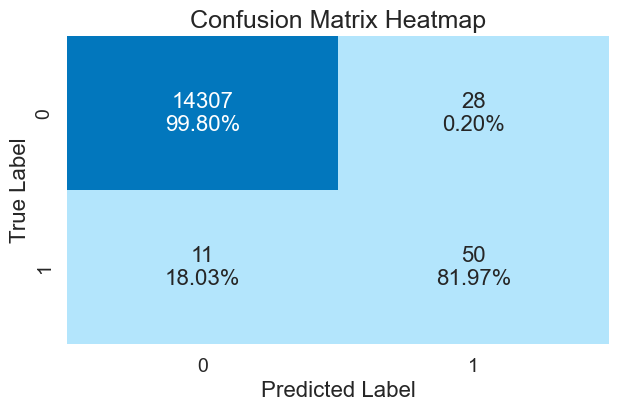

In [50]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# יצירת פלטת צבעים מותאמת אישית
colors = ['#B3E5FC', '#0277BD']  # תכלת כהה יותר וכחול
cmap = sns.color_palette(colors, as_cmap=True)

# חישוב אחוזי הדיוק לכל תא במטריצת הבלבול
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100

# יצירת תוויות המשלבות את המספרים המוחלטים ואת האחוזים
annot = np.array([f'{v1}\n{v2:.2f}%' for v1, v2 in zip(cm.flatten(), cm_perc.flatten())])
annot = annot.reshape(cm.shape)

# יצירת המפה החום עם אחוזים
plt.figure(figsize=(7, 4))
sns.heatmap(cm, annot=annot, fmt='', cmap=cmap, cbar=False, annot_kws={"size": 16})  # הגדלת הכתב בפנים
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.title('Confusion Matrix Heatmap', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### ROC הצגת גרף 

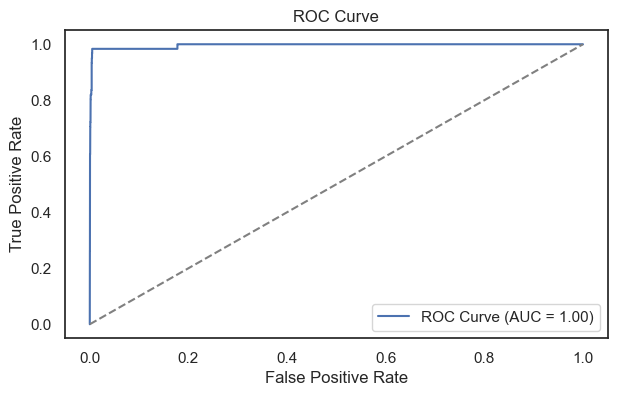

In [51]:
# Plot ROC curve
plt.figure(figsize=(7, 4))
plt.plot(fpr, tpr, color='b', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()